# Example of GECo usage for Graph Classification

## Libraries

In [1]:
import random
import os 
import numpy as np
import torch
import cpuinfo
import platform
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
import torch.nn as nn
from geco_explainer import GECo

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


## Hyperparameters


In [2]:
seed=0
train_perc=0.8
mini_batch_size=32

## Device Identification

In [3]:

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)


so = platform.system()
if (so == "Darwin"):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    dev_name = cpuinfo.get_cpu_info()["brand_raw"]
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    d = str(device)
    if d == 'cuda':
        dev_name = torch.cuda.get_device_name()
        set_seed(seed)
    else:
        dev_name = cpuinfo.get_cpu_info()["brand_raw"]

print(f"Using {device} - {dev_name}")


Using cuda - NVIDIA GeForce RTX 3090 Ti


## MUTAG Dataset loading

In [4]:
root="/tmp/MUTAG"
dataset=TUDataset(root=root,name="MUTAG")
print(f"Number of graphs in the dataset: {len(dataset)}")
print(f"Number of classes {dataset.num_classes}")
print(f"Feature Node dimensionality {dataset.num_features}")

train_size = int(train_perc * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
print("Number of graphs in the training set:",len(train_dataset))
print("Number of graphs in the test set:",len(test_dataset))

Number of graphs in the dataset: 188
Number of classes 2
Feature Node dimensionality 7
Number of graphs in the training set: 150
Number of graphs in the test set: 38


## GNN DEFINITION

In [5]:
class GNN(nn.Module):
    def __init__(self,in_features,hidden_channels,num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels,num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)

        return x

## GNN Training 

In [6]:
num_classes = dataset.num_classes
in_features = dataset.num_features
hidden_channels = 64
lr=1e-2
epochs=1000

model = GNN(in_features, hidden_channels, num_classes).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    epoch_loss=0
    for i,data in enumerate(trainloader):
        # Iterate in batches over the training dataset.
        data=data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        epoch_loss += loss.detach().item()
    epoch_loss /= (i + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch+1, epoch_loss))

Epoch 1, loss 0.6695
Epoch 2, loss 0.6314
Epoch 3, loss 0.6407
Epoch 4, loss 0.6167
Epoch 5, loss 0.6093
Epoch 6, loss 0.5787
Epoch 7, loss 0.5748
Epoch 8, loss 0.6045
Epoch 9, loss 0.5507
Epoch 10, loss 0.5506
Epoch 11, loss 0.5381
Epoch 12, loss 0.5303
Epoch 13, loss 0.5341
Epoch 14, loss 0.5335
Epoch 15, loss 0.5492
Epoch 16, loss 0.5188
Epoch 17, loss 0.5356
Epoch 18, loss 0.5215
Epoch 19, loss 0.5238
Epoch 20, loss 0.5193
Epoch 21, loss 0.5149
Epoch 22, loss 0.5103
Epoch 23, loss 0.5065
Epoch 24, loss 0.5121
Epoch 25, loss 0.5049
Epoch 26, loss 0.5088
Epoch 27, loss 0.5119
Epoch 28, loss 0.4910
Epoch 29, loss 0.5072
Epoch 30, loss 0.5129
Epoch 31, loss 0.5090
Epoch 32, loss 0.5112
Epoch 33, loss 0.5306
Epoch 34, loss 0.5419
Epoch 35, loss 0.5103
Epoch 36, loss 0.5215
Epoch 37, loss 0.5017
Epoch 38, loss 0.5059
Epoch 39, loss 0.4970
Epoch 40, loss 0.4935
Epoch 41, loss 0.5030
Epoch 42, loss 0.5125
Epoch 43, loss 0.5098
Epoch 44, loss 0.5003
Epoch 45, loss 0.4938
Epoch 46, loss 0.48

## Explenation Using GECo

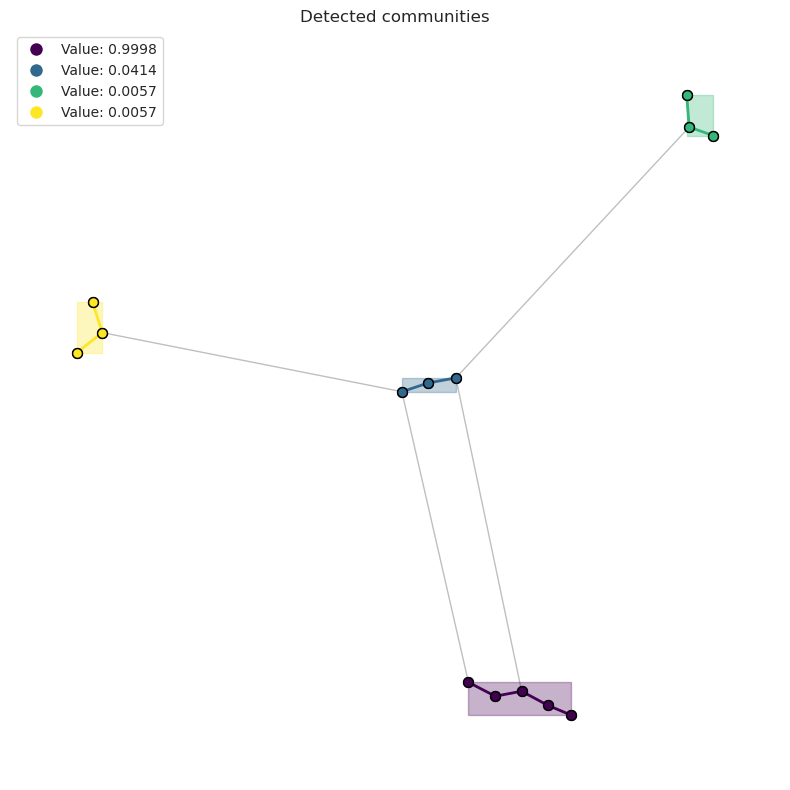

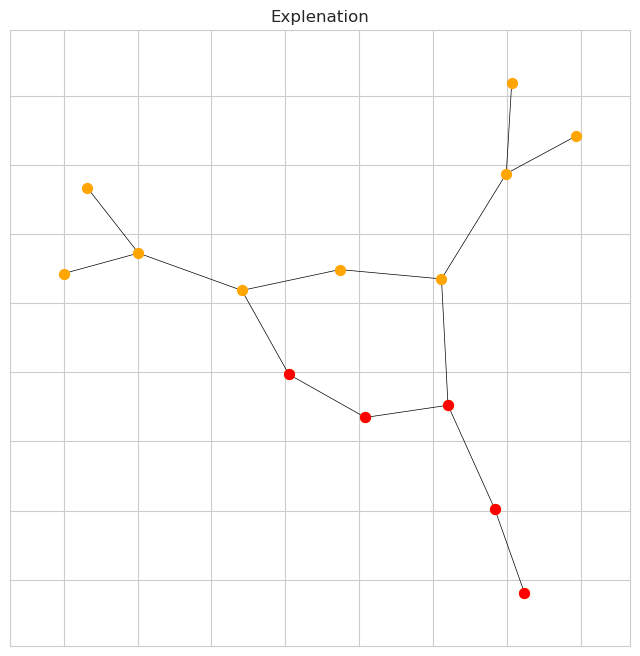

Tau 0.26314835879020393
1. Community [0, 1, 2, 3, 4] (5 nodes) - Probability: 0.9998
2. Community [5, 6, 7] (3 nodes) - Probability: 0.0414
3. Community [8, 9, 10] (3 nodes) - Probability: 0.0057
4. Community [11, 12, 13] (3 nodes) - Probability: 0.0057


In [7]:
geco=GECo(device=device,gnn=model)

graph=test_dataset[23]
pred,_proba=geco.predict(graph)

exp=geco.explain(graph,pred,visualize=True,verbose=True)